# Notebook to test SetFit performance

Check CUDA

In [1]:
import torch
if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Load dataset and transform data

In [2]:
import pandas as pd
import numpy as np

dataFrame = pd.read_pickle(r'../data/7587_corrige.pkl')

In [3]:
subset = dataFrame[['jobTitle', 'description', 'label']].copy()

subset.reset_index(drop=True, inplace=True)
subset.replace('', np.nan, inplace=True)
subset.dropna(inplace=True)

subset['text'] = subset['jobTitle'] + ' ' + subset['description']
subset['label'] = np.where((subset["label"] < 3) | (subset["label"].isna()), 0, 1)
subset = subset[['text','label']]
subset

,text,label
2,Stagiaire ingénieur en intelligence artificiel...,1
3,Stagiaire en développement logiciel Développem...,0
4,Stagiaire en développement Web Création et évo...,0
5,Stagiaire en développement Web Portage d’une a...,0
6,Développeur Data / IA Développement d'applicat...,1
...,...,...
11281,Opérateur production Montage de transmission a...,0
11282,Opérateur production Montage de transmission a...,0
11283,Technicien réparation informatique Reparation ...,0
11284,Technicien réparation Reparation & maintenance...,0


Split between training and test set and truncate the dataset to simulate few-shot context

In [4]:
from datasets import Dataset

def split_train_test(dataset, ratio):
    test_set = dataset.sample(frac = ratio)
    train_set = dataset.drop(test_set.index)
    return train_set, test_set

train_set, test_set = split_train_test(subset, 0.2)

train_ds = Dataset.from_pandas(train_set, split="train")
test_ds = Dataset.from_pandas(test_set, split="test")

In [5]:
from setfit import sample_dataset

train_dataset = sample_dataset(train_ds, label_column="label", num_samples=10)
test_dataset = test_ds
print(train_dataset)

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 20
})


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Load a pre trained sentence transformers to be used by SetFit

In [6]:
from setfit import SetFitModel

# Load SetFit model from Hub
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")
model.to("cuda")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


SetFitModel(model_body=SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
), model_head=LogisticRegression(), multi_target_strategy=None, normalize_embeddings=False, labels=None, model_card_data=SetFitModelCardData(language=None, license=None, tags=['setfit', 'sentence-transformers', 'text-classification', 'generated_from_setfit_trainer'], model_name='SetFit with sentence-transformers/paraphrase-mpnet-base-v2', model_id=None, dataset_name=None, dataset_id=None, dataset_revision=None, task_name=None, st_id='sentence-transformers/paraphrase-mpnet-base-v2', hyperparameters={}, eval_results_dict={}, eval_lines_list=[], metric_l

In [7]:
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import Trainer, TrainingArguments
from sklearn.metrics import f1_score, accuracy_score

# Create trainer

def compute_metrics(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return { 'accuracy': accuracy, 'f1': f1}

trainer_arguments = TrainingArguments(
	loss=CosineSimilarityLoss,
    batch_size=(8,2),
    num_iterations=20, # Number of text pairs to generate for contrastive learning
    num_epochs=(1,10) # Number of epochs to use for contrastive learning (for the transformer and for the classification head)
)

trainer = Trainer(
    model=model,
    args=trainer_arguments,
    metric=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Training and evaluation

In [8]:
# trainer.train()

How to save/load the fine tuned model

In [9]:
# metrics = trainer.evaluate()
# metrics

In [10]:
# model._save_pretrained(r'../models/setfit') # The given folder must exist

In [11]:
# model = SetFitModel._from_pretrained(r'../models/setfit')

A small example on unseen data

In [12]:
# preds = model(["Mon rôle chez DreamQuark, est de résoudre les problématiques des différents acteurs autour de la\nbanque et assurance (Churn, upsale, cross-sale etc.) à travers des techniques de Machine\nLearning/Deep learning","• Utilisation de Flask et d’Elasticsearch afin de créer une API\nREST pour faire des recherches sur des régions de\nplanètes."])
# print("predictions: ", preds,"expected: ",[1,0])

Free memory

In [13]:
del model
torch.cuda.empty_cache()

# Tests on hyper parameters

In [14]:
import gc

num_classes = 2

def get_transformer_model(model_name):
    model = SetFitModel.from_pretrained(model_name)
    gc.collect()
    torch.cuda.empty_cache()
    
    return model.to('cuda')

def init_trainer(model, loss, train_dataset, test_dataset):
    trainer_arguments = TrainingArguments(
        loss=loss,
        batch_size=(8,2),
        num_iterations=20, # Number of text pairs to generate for contrastive learning
        num_epochs=(1,10) # Number of epochs to use for contrastive learning (for the transformer and for the classification head)
    )

    trainer = Trainer(
        model=model,
        args=trainer_arguments,
        metric='f1',
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )
    return trainer

def setfit_f1_score(train_set, test_set, model_name, loss):   
    if len(train_set) <= 1 or len(test_set) <= 1:
        raise Exception
    
    model = get_transformer_model(model_name)
    trainer = init_trainer(model, loss, train_set, test_set)
    
    trainer.train()
    metrics = trainer.evaluate()
    
    del model
    del trainer
    torch.cuda.empty_cache()
    
    return metrics['f1']

In [15]:
from langdetect import detect

def filter_lang(df, lang):
    indices = []
    for i in range(len(df)):
        try:
            l = detect(df.iloc[i]["text"])
            if l == lang:
                indices.append(i)
        except:""
    
    return df.iloc[indices]

def filter_dataset(data, min_text_length=None, max_text_length=None, lang=None):
    if min_text_length is None:
        if max_text_length is None:
            filtered_data = data
        else:
            filtered_data = data[data['text'].str.split().apply(len) <= max_text_length]
    else:
        if max_text_length is None:
            filtered_data = data[data['text'].str.split().apply(len) >= min_text_length]
        else:
            filtered_data = data[data['text'].str.split().apply(len).between(min_text_length, max_text_length)]
            
    if not (lang is None):
        filtered_data = filter_lang(filtered_data, lang)
           
    return filtered_data

### N-Shots

In [31]:
n_values = [1,5,10,15,20]
results = {}
for n_shot in n_values:
	results[n_shot] = 0.0

n_iter = 2

for i in range(n_iter):
	# Use the same subset of the dataset for all of the tests in the following loop
	n_values_max = np.max(n_values)
	new_train_set = train_set.sample(frac = 1).groupby('label').head(n_values_max)
	new_train_set = Dataset.from_pandas(new_train_set, split="train")
	new_test_set = Dataset.from_pandas(test_set, split="test")

	for n_shot in n_values:
		if n_shot in results:
			try:
				n_iter_shot = 2 if n_shot < n_values_max else 1
				for iter in range(n_iter_shot):
					train_set_n_shot = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=42*n_iter + 7*n_shot)
					results[n_shot] += setfit_f1_score(train_set_n_shot, new_test_set, "sentence-transformers/paraphrase-mpnet-base-v2", CosineSimilarityLoss)/n_iter_shot
			except:
				del results[n_shot]

for n_shot in n_values:
	results[n_shot] /= n_iter

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 80
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.0938, 'learning_rate': 2e-05, 'epoch': 0.1}
{'train_runtime': 4.346, 'train_samples_per_second': 18.408, 'train_steps_per_second': 2.301, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 80
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.0938, 'learning_rate': 2e-05, 'epoch': 0.1}
{'train_runtime': 3.111, 'train_samples_per_second': 25.715, 'train_steps_per_second': 3.214, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 400
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_loss': 0.1471, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}
{'embedding_loss': 0.0013, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 110.9378, 'train_samples_per_second': 3.606, 'train_steps_per_second': 0.451, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 400
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_loss': 0.1471, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}
{'embedding_loss': 0.0013, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 178.365, 'train_samples_per_second': 2.243, 'train_steps_per_second': 0.28, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 100


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'embedding_loss': 0.2485, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0004, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 386.6623, 'train_samples_per_second': 2.069, 'train_steps_per_second': 0.259, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 100


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'embedding_loss': 0.2485, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0004, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 223.881, 'train_samples_per_second': 3.573, 'train_steps_per_second': 0.447, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1200
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 150


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

{'embedding_loss': 0.3355, 'learning_rate': 1.3333333333333334e-06, 'epoch': 0.01}
{'embedding_loss': 0.0017, 'learning_rate': 1.4814814814814815e-05, 'epoch': 0.33}
{'embedding_loss': 0.0004, 'learning_rate': 7.4074074074074075e-06, 'epoch': 0.67}
{'embedding_loss': 0.0002, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 340.8968, 'train_samples_per_second': 3.52, 'train_steps_per_second': 0.44, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1200
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 150


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

{'embedding_loss': 0.3355, 'learning_rate': 1.3333333333333334e-06, 'epoch': 0.01}
{'embedding_loss': 0.0017, 'learning_rate': 1.4814814814814815e-05, 'epoch': 0.33}
{'embedding_loss': 0.0004, 'learning_rate': 7.4074074074074075e-06, 'epoch': 0.67}
{'embedding_loss': 0.0002, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 326.4777, 'train_samples_per_second': 3.676, 'train_steps_per_second': 0.459, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1600
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 200


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

{'embedding_loss': 0.3163, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'embedding_loss': 0.0036, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.25}
{'embedding_loss': 0.0005, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0002, 'learning_rate': 5.555555555555557e-06, 'epoch': 0.75}
{'embedding_loss': 0.0004, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 332.85, 'train_samples_per_second': 4.807, 'train_steps_per_second': 0.601, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 80
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.0176, 'learning_rate': 2e-05, 'epoch': 0.1}
{'train_runtime': 3.312, 'train_samples_per_second': 24.155, 'train_steps_per_second': 3.019, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 80
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.0176, 'learning_rate': 2e-05, 'epoch': 0.1}


***** Running evaluation *****


{'train_runtime': 1.31, 'train_samples_per_second': 61.069, 'train_steps_per_second': 7.634, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 400
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_loss': 0.1641, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}


***** Running evaluation *****


{'embedding_loss': 0.0026, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 18.307, 'train_samples_per_second': 21.85, 'train_steps_per_second': 2.731, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 400
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_loss': 0.1641, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}


***** Running evaluation *****


{'embedding_loss': 0.0026, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 18.289, 'train_samples_per_second': 21.871, 'train_steps_per_second': 2.734, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 100


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'embedding_loss': 0.2144, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'embedding_loss': 0.0018, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}


***** Running evaluation *****


{'embedding_loss': 0.0007, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 27.85, 'train_samples_per_second': 28.725, 'train_steps_per_second': 3.591, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 100


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'embedding_loss': 0.2144, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'embedding_loss': 0.0018, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}


***** Running evaluation *****


{'embedding_loss': 0.0007, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 27.814, 'train_samples_per_second': 28.762, 'train_steps_per_second': 3.595, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1200
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 150


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

{'embedding_loss': 0.2683, 'learning_rate': 1.3333333333333334e-06, 'epoch': 0.01}
{'embedding_loss': 0.0017, 'learning_rate': 1.4814814814814815e-05, 'epoch': 0.33}
{'embedding_loss': 0.0001, 'learning_rate': 7.4074074074074075e-06, 'epoch': 0.67}
{'embedding_loss': 0.0004, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 51.394, 'train_samples_per_second': 23.349, 'train_steps_per_second': 2.919, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1200
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 150


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

{'embedding_loss': 0.2683, 'learning_rate': 1.3333333333333334e-06, 'epoch': 0.01}
{'embedding_loss': 0.0017, 'learning_rate': 1.4814814814814815e-05, 'epoch': 0.33}
{'embedding_loss': 0.0001, 'learning_rate': 7.4074074074074075e-06, 'epoch': 0.67}
{'embedding_loss': 0.0004, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 52.243, 'train_samples_per_second': 22.97, 'train_steps_per_second': 2.871, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1600
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 200


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

{'embedding_loss': 0.2515, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'embedding_loss': 0.0017, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.25}
{'embedding_loss': 0.0002, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0004, 'learning_rate': 5.555555555555557e-06, 'epoch': 0.75}
{'embedding_loss': 0.0002, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 109.591, 'train_samples_per_second': 14.6, 'train_steps_per_second': 1.825, 'epoch': 1.0}


***** Running evaluation *****


In [17]:
import matplotlib.pyplot as plt

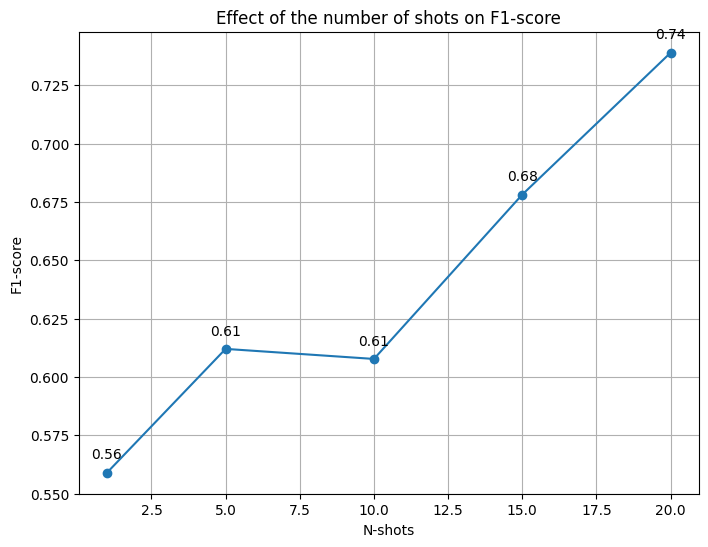

In [32]:
x = results.keys()
y = results.values()
 
plt.figure(figsize=(8, 6))
plt.plot(x, y, marker='o', linestyle='-')
 
for i, (xi, yi) in enumerate(zip(x, y)):
    plt.annotate(f'{yi:.2f}', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')
 
plt.title('Effect of the number of shots on F1-score')
plt.xlabel('N-shots')
plt.ylabel('F1-score')
 
plt.grid(True)
plt.show()

### Input length

In [19]:
results = {}
len_values = [(0,1),(0,3),(0,5),(0,10),(0,50),(0,100)]
new_test_set = Dataset.from_pandas(test_set, split="test")
nbIter = 5

for i in range(len(len_values)):
	results[f"[{len_values[i][0]},{len_values[i][1]}]"] = 0.0
results['all'] = 0.0

# Repeat the tests multiple times because F1-score variations might be due to the examples chosen and not the input length of those examples
for iter in range(nbIter):
	print("Step:",iter,"/",nbIter)
	for i in range(len(len_values)):
		key = f"[{len_values[i][0]},{len_values[i][1]}]"
		if key in results:
			try:
					new_train_set = filter_dataset(train_set, len_values[i][0], len_values[i][1])
					new_train_set = Dataset.from_pandas(new_train_set, split="train")
					new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=8, seed=(13*iter))
					results[key] += setfit_f1_score(new_train_set, new_test_set, "sentence-transformers/paraphrase-mpnet-base-v2", CosineSimilarityLoss)
			except:
				del results[key]
  
	# Additional tests (no length constraint and only data with a legnth greater than 5)
	if 'all' in results:
		new_train_set = Dataset.from_pandas(train_set, split="train")
		new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=8)
		results['all'] += setfit_f1_score(new_train_set, new_test_set, "sentence-transformers/paraphrase-mpnet-base-v2", CosineSimilarityLoss)

# Mean of F1-scores
for key in results.keys():
	results[key] /= nbIter

Step: 0 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this 

Map:   0%|          | 0/8 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 320
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/12 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 480
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 60


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

{'embedding_loss': 0.1339, 'learning_rate': 3.3333333333333333e-06, 'epoch': 0.02}
{'embedding_loss': 0.0076, 'learning_rate': 3.7037037037037037e-06, 'epoch': 0.83}


***** Running evaluation *****


{'train_runtime': 4.683, 'train_samples_per_second': 102.498, 'train_steps_per_second': 12.812, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1232, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0004, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 7.272, 'train_samples_per_second': 88.009, 'train_steps_per_second': 11.001, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1555, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0002, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 14.925, 'train_samples_per_second': 42.881, 'train_steps_per_second': 5.36, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.0999, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0008, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 14.859, 'train_samples_per_second': 43.072, 'train_steps_per_second': 5.384, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1891, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 23.856, 'train_samples_per_second': 26.828, 'train_steps_per_second': 3.353, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1694, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0011, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 25.728, 'train_samples_per_second': 24.876, 'train_steps_per_second': 3.109, 'epoch': 1.0}


***** Running evaluation *****


Step: 1 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/12 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 480
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 60


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

{'embedding_loss': 0.0547, 'learning_rate': 3.3333333333333333e-06, 'epoch': 0.02}
{'embedding_loss': 0.0011, 'learning_rate': 3.7037037037037037e-06, 'epoch': 0.83}


***** Running evaluation *****


{'train_runtime': 4.519, 'train_samples_per_second': 106.218, 'train_steps_per_second': 13.277, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.205, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0014, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 7.752, 'train_samples_per_second': 82.559, 'train_steps_per_second': 10.32, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1139, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0006, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 14.275, 'train_samples_per_second': 44.834, 'train_steps_per_second': 5.604, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1945, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0004, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 21.87, 'train_samples_per_second': 29.264, 'train_steps_per_second': 3.658, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1891, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 23.892, 'train_samples_per_second': 26.787, 'train_steps_per_second': 3.348, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1694, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0011, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 25.579, 'train_samples_per_second': 25.021, 'train_steps_per_second': 3.128, 'epoch': 1.0}


***** Running evaluation *****


Step: 2 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/12 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 480
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 60


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

{'embedding_loss': 0.1149, 'learning_rate': 3.3333333333333333e-06, 'epoch': 0.02}
{'embedding_loss': 0.0008, 'learning_rate': 3.7037037037037037e-06, 'epoch': 0.83}


***** Running evaluation *****


{'train_runtime': 4.733, 'train_samples_per_second': 101.416, 'train_steps_per_second': 12.677, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1657, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0021, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 6.985, 'train_samples_per_second': 91.625, 'train_steps_per_second': 11.453, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1282, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0012, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 14.05, 'train_samples_per_second': 45.552, 'train_steps_per_second': 5.694, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1594, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0013, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 20.571, 'train_samples_per_second': 31.112, 'train_steps_per_second': 3.889, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1891, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 23.827, 'train_samples_per_second': 26.86, 'train_steps_per_second': 3.358, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1694, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0011, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 25.72, 'train_samples_per_second': 24.883, 'train_steps_per_second': 3.11, 'epoch': 1.0}


***** Running evaluation *****


Step: 3 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/12 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 480
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 60


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

{'embedding_loss': 0.1142, 'learning_rate': 3.3333333333333333e-06, 'epoch': 0.02}
{'embedding_loss': 0.0033, 'learning_rate': 3.7037037037037037e-06, 'epoch': 0.83}


***** Running evaluation *****


{'train_runtime': 4.639, 'train_samples_per_second': 103.471, 'train_steps_per_second': 12.934, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1532, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0038, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 7.747, 'train_samples_per_second': 82.613, 'train_steps_per_second': 10.327, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.0851, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0006, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 13.961, 'train_samples_per_second': 45.842, 'train_steps_per_second': 5.73, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.152, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0023, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 21.268, 'train_samples_per_second': 30.092, 'train_steps_per_second': 3.762, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1891, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 23.804, 'train_samples_per_second': 26.886, 'train_steps_per_second': 3.361, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1694, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0011, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 25.598, 'train_samples_per_second': 25.002, 'train_steps_per_second': 3.125, 'epoch': 1.0}


***** Running evaluation *****


Step: 4 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/12 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 480
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 60


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

{'embedding_loss': 0.0514, 'learning_rate': 3.3333333333333333e-06, 'epoch': 0.02}
{'embedding_loss': 0.0019, 'learning_rate': 3.7037037037037037e-06, 'epoch': 0.83}


***** Running evaluation *****


{'train_runtime': 4.4, 'train_samples_per_second': 109.091, 'train_steps_per_second': 13.636, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1655, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0019, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 7.141, 'train_samples_per_second': 89.623, 'train_steps_per_second': 11.203, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2048, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0018, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 15.519, 'train_samples_per_second': 41.24, 'train_steps_per_second': 5.155, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2123, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.001, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 20.954, 'train_samples_per_second': 30.543, 'train_steps_per_second': 3.818, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1891, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 23.933, 'train_samples_per_second': 26.741, 'train_steps_per_second': 3.343, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1694, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0011, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 25.722, 'train_samples_per_second': 24.881, 'train_steps_per_second': 3.11, 'epoch': 1.0}


***** Running evaluation *****


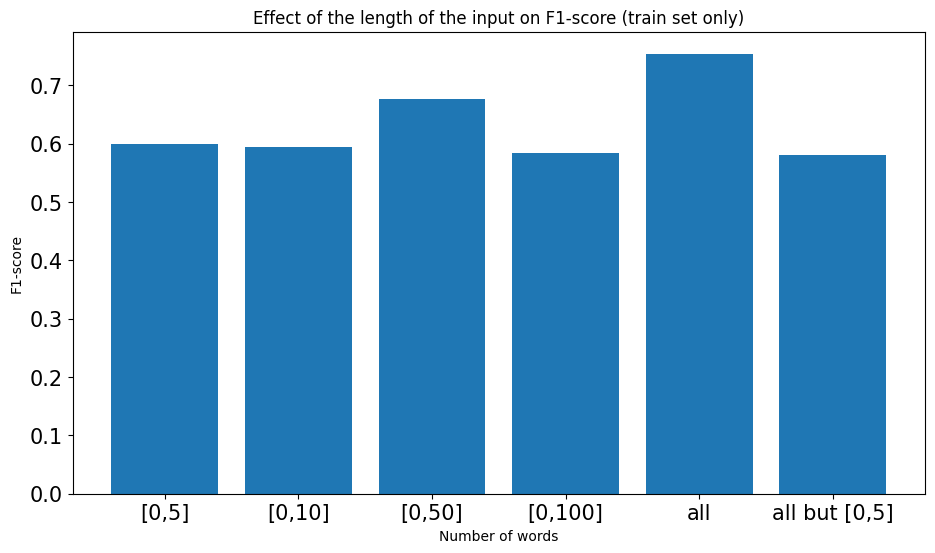

In [20]:
x = results.keys()
y = results.values()
 
plt.figure(figsize=(11, 6))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.bar(x, y)

plt.title('Effect of the length of the input on F1-score (train set only)')
plt.xlabel('Number of words')
plt.ylabel('F1-score')

plt.show()

### Distances

In [21]:
from sentence_transformers.losses import BatchAllTripletLoss

n_iter = 10
results = {}

results['Triplet'] = 0.0
results['Cosine'] = 0.0

new_test_set = Dataset.from_pandas(test_set, split="test")

for i in range(n_iter):
	new_train_set = Dataset.from_pandas(train_set, split="train")
	new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=8)

	results['Triplet'] += setfit_f1_score(new_train_set, new_test_set, "sentence-transformers/paraphrase-mpnet-base-v2", BatchAllTripletLoss)
	results['Cosine'] += setfit_f1_score(new_train_set, new_test_set, "sentence-transformers/paraphrase-mpnet-base-v2", CosineSimilarityLoss)

results['Triplet']/=n_iter
results['Cosine']/=n_iter

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.23, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.7053, 'train_samples_per_second': 22.686, 'train_steps_per_second': 2.836, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1891, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 23.845, 'train_samples_per_second': 26.84, 'train_steps_per_second': 3.355, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.23, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.44, 'train_samples_per_second': 36.364, 'train_steps_per_second': 4.545, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1891, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 23.919, 'train_samples_per_second': 26.757, 'train_steps_per_second': 3.345, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.23, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.422, 'train_samples_per_second': 37.915, 'train_steps_per_second': 4.739, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1891, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 23.867, 'train_samples_per_second': 26.815, 'train_steps_per_second': 3.352, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.23, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.376, 'train_samples_per_second': 42.553, 'train_steps_per_second': 5.319, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1891, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 23.838, 'train_samples_per_second': 26.848, 'train_steps_per_second': 3.356, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.23, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.521, 'train_samples_per_second': 30.71, 'train_steps_per_second': 3.839, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1891, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 23.805, 'train_samples_per_second': 26.885, 'train_steps_per_second': 3.361, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.23, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.472, 'train_samples_per_second': 33.898, 'train_steps_per_second': 4.237, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1891, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 23.813, 'train_samples_per_second': 26.876, 'train_steps_per_second': 3.36, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.23, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.437, 'train_samples_per_second': 36.613, 'train_steps_per_second': 4.577, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1891, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 23.9, 'train_samples_per_second': 26.778, 'train_steps_per_second': 3.347, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.23, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.52, 'train_samples_per_second': 30.769, 'train_steps_per_second': 3.846, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1891, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 23.847, 'train_samples_per_second': 26.838, 'train_steps_per_second': 3.355, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.23, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.387, 'train_samples_per_second': 41.344, 'train_steps_per_second': 5.168, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1891, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 23.772, 'train_samples_per_second': 26.922, 'train_steps_per_second': 3.365, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.23, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 0.45, 'train_samples_per_second': 35.556, 'train_steps_per_second': 4.444, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1891, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 23.797, 'train_samples_per_second': 26.894, 'train_steps_per_second': 3.362, 'epoch': 1.0}


***** Running evaluation *****


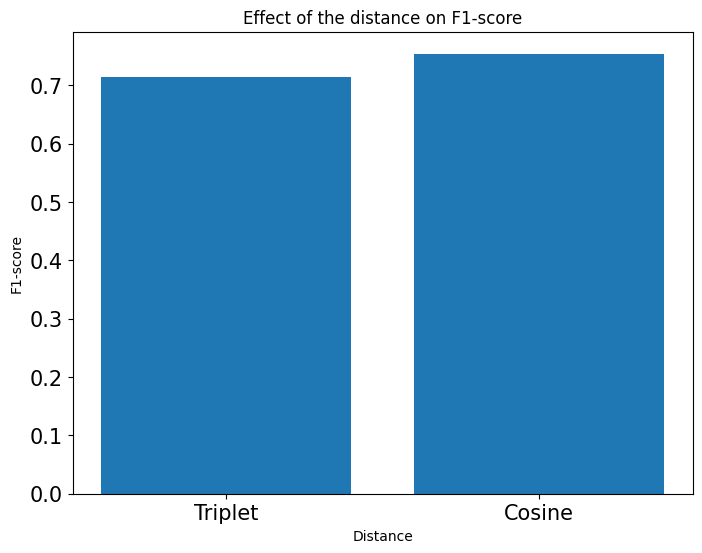

In [22]:
x = results.keys()
y = results.values()

plt.figure(figsize=(8, 6))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.bar(x, y)

plt.title('Effect of the distance on F1-score')
plt.xlabel('Distance')
plt.ylabel('F1-score')

plt.show()

### Language

In [23]:
results = {}
n_iter = 10

results['fr'] = 0.0
results['en'] = 0.0
results['both'] = 0.0

for i in range(n_iter):
	fr_train_set_panda = filter_dataset(train_set, lang='fr')
	fr_train_set = Dataset.from_pandas(fr_train_set_panda, split="train")
	fr_train_set = sample_dataset(fr_train_set, label_column="label", num_samples=8)
	fr_test_set_panda = filter_dataset(test_set, lang='fr')
	fr_test_set = Dataset.from_pandas(fr_test_set_panda, split="test")

	en_train_set_panda = filter_dataset(train_set, lang='en')
	en_train_set = Dataset.from_pandas(en_train_set_panda, split="train")
	en_train_set = sample_dataset(en_train_set, label_column="label", num_samples=8)
	en_test_set_panda = filter_dataset(test_set, lang='en')
	en_test_set = Dataset.from_pandas(en_test_set_panda, split="test")

	mix_train_set = pd.concat([fr_train_set_panda, en_train_set_panda])
	mix_train_set = Dataset.from_pandas(mix_train_set, split="test")
	mix_train_set = sample_dataset(mix_train_set, label_column="label", num_samples=8)
	mix_test_set = pd.concat([fr_test_set_panda, en_test_set_panda])
	mix_test_set = Dataset.from_pandas(mix_test_set, split="test")

	results['fr'] += setfit_f1_score(fr_train_set, fr_test_set, "sentence-transformers/paraphrase-mpnet-base-v2", CosineSimilarityLoss) 
	results['en'] += setfit_f1_score(en_train_set, en_test_set, "sentence-transformers/paraphrase-mpnet-base-v2", CosineSimilarityLoss)
	results['both'] += setfit_f1_score(mix_train_set, mix_test_set, "sentence-transformers/paraphrase-mpnet-base-v2", CosineSimilarityLoss)
 
results['fr'] /= n_iter
results['en'] /= n_iter
results['both'] /= n_iter

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this 

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1345, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0024, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 27.8969, 'train_samples_per_second': 22.942, 'train_steps_per_second': 2.868, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1067, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0029, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 31.933, 'train_samples_per_second': 20.042, 'train_steps_per_second': 2.505, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1153, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0011, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 25.616, 'train_samples_per_second': 24.984, 'train_steps_per_second': 3.123, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.139, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0006, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 44.242, 'train_samples_per_second': 14.466, 'train_steps_per_second': 1.808, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1088, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.004, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 28.226, 'train_samples_per_second': 22.674, 'train_steps_per_second': 2.834, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1161, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0017, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 34.562, 'train_samples_per_second': 18.517, 'train_steps_per_second': 2.315, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1583, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0016, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 43.562, 'train_samples_per_second': 14.692, 'train_steps_per_second': 1.836, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1352, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.002, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 26.142, 'train_samples_per_second': 24.482, 'train_steps_per_second': 3.06, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1505, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0008, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 50.174, 'train_samples_per_second': 12.756, 'train_steps_per_second': 1.594, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1587, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0006, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 46.167, 'train_samples_per_second': 13.863, 'train_steps_per_second': 1.733, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1731, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0025, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 24.026, 'train_samples_per_second': 26.638, 'train_steps_per_second': 3.33, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1443, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.002, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 29.032, 'train_samples_per_second': 22.045, 'train_steps_per_second': 2.756, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1545, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.001, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 49.667, 'train_samples_per_second': 12.886, 'train_steps_per_second': 1.611, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1008, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0021, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 15.191, 'train_samples_per_second': 42.13, 'train_steps_per_second': 5.266, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1928, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0008, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 62.335, 'train_samples_per_second': 10.267, 'train_steps_per_second': 1.283, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1405, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0008, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 39.508, 'train_samples_per_second': 16.199, 'train_steps_per_second': 2.025, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1068, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.004, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 22.463, 'train_samples_per_second': 28.491, 'train_steps_per_second': 3.561, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2028, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0008, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 87.965, 'train_samples_per_second': 7.276, 'train_steps_per_second': 0.909, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.125, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0009, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 116.0507, 'train_samples_per_second': 5.515, 'train_steps_per_second': 0.689, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1192, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0065, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 42.482, 'train_samples_per_second': 15.065, 'train_steps_per_second': 1.883, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.0986, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0088, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 36.573, 'train_samples_per_second': 17.499, 'train_steps_per_second': 2.187, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1328, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0014, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 122.0201, 'train_samples_per_second': 5.245, 'train_steps_per_second': 0.656, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1567, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0017, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 33.032, 'train_samples_per_second': 19.375, 'train_steps_per_second': 2.422, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1605, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.001, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 39.405, 'train_samples_per_second': 16.242, 'train_steps_per_second': 2.03, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1687, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0009, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 47.024, 'train_samples_per_second': 13.61, 'train_steps_per_second': 1.701, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1702, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0031, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 22.764, 'train_samples_per_second': 28.115, 'train_steps_per_second': 3.514, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1766, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0012, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 31.416, 'train_samples_per_second': 20.372, 'train_steps_per_second': 2.546, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1299, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0005, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 40.29, 'train_samples_per_second': 15.885, 'train_steps_per_second': 1.986, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1254, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0009, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 25.416, 'train_samples_per_second': 25.181, 'train_steps_per_second': 3.148, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1491, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0013, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 29.398, 'train_samples_per_second': 21.77, 'train_steps_per_second': 2.721, 'epoch': 1.0}


***** Running evaluation *****


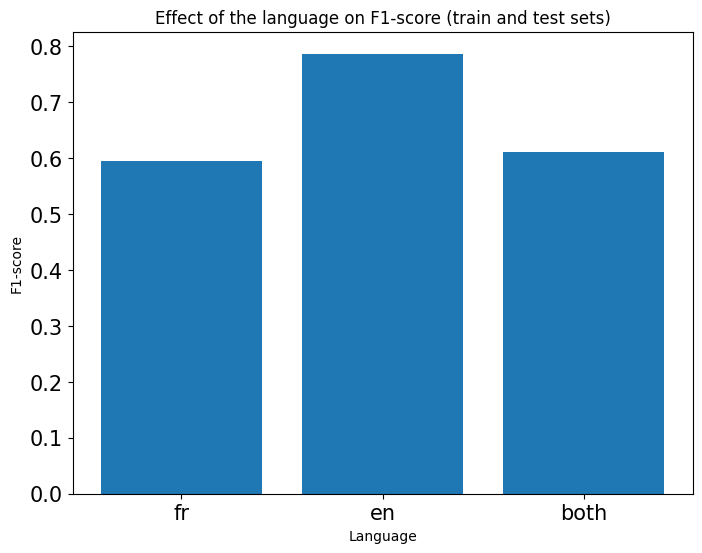

In [24]:
x = results.keys()
y = results.values()

plt.figure(figsize=(8, 6))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.bar(x, y)

plt.title('Effect of the language on F1-score (train and test sets)')
plt.xlabel('Language')
plt.ylabel('F1-score')

plt.show()

### Sentence transformers

Test SetFit with different ST models

In [25]:
results = {}
models = {
	"paraphrase-mpnet-base-v2": "sentence-transformers/paraphrase-mpnet-base-v2",
 	"all-MiniLM-L6-v2": "sentence-transformers/all-MiniLM-L6-v2",
	"paraphrase-multilingual-MiniLM-L12-v2": "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
	"paraphrase-multilingual-mpnet-base-v2": "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
	"multilingual-e5-small": "intfloat/multilingual-e5-small",
	"all-distilroberta-v1": "sentence-transformers/all-distilroberta-v1",
	"msmarco-distilbert-dot-v5": "sentence-transformers/msmarco-distilbert-dot-v5",
 	"bge-small-en-v1.5": "BAAI/bge-small-en-v1.5",
  	"all-roberta-large-v1": "sentence-transformers/all-roberta-large-v1"
}

new_test_set = Dataset.from_pandas(test_set, split="test")
n_iter = 5

for key in models.keys():
    results[key] = 0.0

for i in range(n_iter):
	# Use the same subset of the dataset for all of the tests in the following loop
	new_train_set = Dataset.from_pandas(train_set, split="train")
	new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=8)

	for key, full_model_name in models.items():
		try:
			results[key] += setfit_f1_score(new_train_set, new_test_set, full_model_name, CosineSimilarityLoss)
		except: ""
  
for key in results.keys():
    results[key] /= n_iter

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1891, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 23.851, 'train_samples_per_second': 26.833, 'train_steps_per_second': 3.354, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1722, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0206, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 4.93, 'train_samples_per_second': 129.817, 'train_steps_per_second': 16.227, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2031, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0064, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 8.801, 'train_samples_per_second': 72.719, 'train_steps_per_second': 9.09, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1984, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0011, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 21.081, 'train_samples_per_second': 30.359, 'train_steps_per_second': 3.795, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.3765, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.1117, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 10.986, 'train_samples_per_second': 58.256, 'train_steps_per_second': 7.282, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2199, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0052, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 13.728, 'train_samples_per_second': 46.62, 'train_steps_per_second': 5.828, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.292, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.014, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 12.6292, 'train_samples_per_second': 50.676, 'train_steps_per_second': 6.335, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.234, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0302, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 9.772, 'train_samples_per_second': 65.493, 'train_steps_per_second': 8.187, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2311, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0002, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 295.432, 'train_samples_per_second': 2.166, 'train_steps_per_second': 0.271, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1891, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 25.078, 'train_samples_per_second': 25.52, 'train_steps_per_second': 3.19, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1722, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0206, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 5.189, 'train_samples_per_second': 123.338, 'train_steps_per_second': 15.417, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2031, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0064, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 9.185, 'train_samples_per_second': 69.679, 'train_steps_per_second': 8.71, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1984, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0011, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 22.283, 'train_samples_per_second': 28.721, 'train_steps_per_second': 3.59, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.3765, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.1117, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 11.537, 'train_samples_per_second': 55.474, 'train_steps_per_second': 6.934, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2199, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0052, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 14.474, 'train_samples_per_second': 44.217, 'train_steps_per_second': 5.527, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.292, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.014, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 13.023, 'train_samples_per_second': 49.144, 'train_steps_per_second': 6.143, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.234, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0302, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 9.755, 'train_samples_per_second': 65.607, 'train_steps_per_second': 8.201, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2311, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0002, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 641.6822, 'train_samples_per_second': 0.997, 'train_steps_per_second': 0.125, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1891, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 24.243, 'train_samples_per_second': 26.399, 'train_steps_per_second': 3.3, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1722, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0206, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 4.937, 'train_samples_per_second': 129.633, 'train_steps_per_second': 16.204, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2031, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0064, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 8.882, 'train_samples_per_second': 72.056, 'train_steps_per_second': 9.007, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1984, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0011, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 21.353, 'train_samples_per_second': 29.972, 'train_steps_per_second': 3.747, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.3765, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.1117, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 11.186, 'train_samples_per_second': 57.214, 'train_steps_per_second': 7.152, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2199, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0052, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 13.917, 'train_samples_per_second': 45.987, 'train_steps_per_second': 5.748, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.292, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.014, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 12.358, 'train_samples_per_second': 51.788, 'train_steps_per_second': 6.474, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.234, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0302, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 9.412, 'train_samples_per_second': 67.998, 'train_steps_per_second': 8.5, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2311, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0002, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 467.2149, 'train_samples_per_second': 1.37, 'train_steps_per_second': 0.171, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1891, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 25.068, 'train_samples_per_second': 25.531, 'train_steps_per_second': 3.191, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1722, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0206, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 5.318, 'train_samples_per_second': 120.346, 'train_steps_per_second': 15.043, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2031, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0064, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 9.379, 'train_samples_per_second': 68.238, 'train_steps_per_second': 8.53, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1984, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0011, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 22.285, 'train_samples_per_second': 28.719, 'train_steps_per_second': 3.59, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.3765, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.1117, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 11.779, 'train_samples_per_second': 54.334, 'train_steps_per_second': 6.792, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2199, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0052, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 14.576, 'train_samples_per_second': 43.908, 'train_steps_per_second': 5.488, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.292, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.014, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 13.086, 'train_samples_per_second': 48.907, 'train_steps_per_second': 6.113, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.234, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0302, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 9.933, 'train_samples_per_second': 64.432, 'train_steps_per_second': 8.054, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2311, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0002, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 457.2105, 'train_samples_per_second': 1.4, 'train_steps_per_second': 0.175, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1891, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 26.958, 'train_samples_per_second': 23.741, 'train_steps_per_second': 2.968, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1722, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0206, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 5.245, 'train_samples_per_second': 122.021, 'train_steps_per_second': 15.253, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2031, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0064, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 9.265, 'train_samples_per_second': 69.077, 'train_steps_per_second': 8.635, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1984, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0011, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 22.427, 'train_samples_per_second': 28.537, 'train_steps_per_second': 3.567, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.3765, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.1117, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 11.823, 'train_samples_per_second': 54.132, 'train_steps_per_second': 6.766, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2199, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0052, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 14.468, 'train_samples_per_second': 44.236, 'train_steps_per_second': 5.529, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.292, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.014, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 12.791, 'train_samples_per_second': 50.035, 'train_steps_per_second': 6.254, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.234, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0302, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 9.726, 'train_samples_per_second': 65.803, 'train_steps_per_second': 8.225, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2311, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0002, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 392.1544, 'train_samples_per_second': 1.632, 'train_steps_per_second': 0.204, 'epoch': 1.0}


***** Running evaluation *****


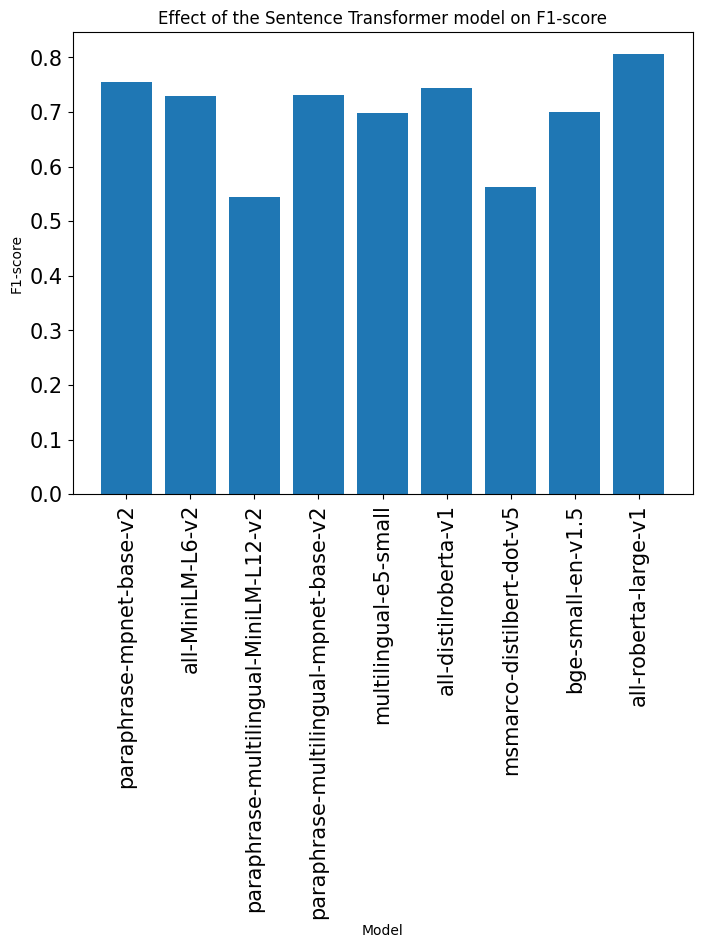

In [26]:
x = results.keys()
y = results.values()

plt.figure(figsize=(8, 6))
plt.xticks(fontsize=15, rotation='vertical')
plt.yticks(fontsize=15)
plt.bar(x, y)

plt.title('Effect of the Sentence Transformer model on F1-score')
plt.xlabel('Model')
plt.ylabel('F1-score')

plt.show()

### Hyperparameter Optimization (with optuna)

In [27]:
from typing import Dict, Any, Union
from optuna import Trial

def model_init(params: Dict[str, Any]) -> SetFitModel:
    params = params or {}
    max_iter = params.get("max_iter", 100)
    solver = params.get("solver", "liblinear")
    params = {
        "head_params": {
            "max_iter": max_iter,
            "solver": solver,
        }
    }
    return SetFitModel.from_pretrained("sentence-transformers/paraphrase-multilingual-mpnet-base-v2", **params)

def hp_space(trial: Trial) -> Dict[str, Union[float, int, str]]:
    return {
        "body_learning_rate": trial.suggest_float("body_learning_rate", 1e-6, 1e-3, log=True),
        "num_epochs": trial.suggest_int("num_epochs", 1, 2),
        "batch_size": trial.suggest_categorical("batch_size", [8, 16, 32]),
        "seed": trial.suggest_int("seed", 1, 40),
        "max_iter": trial.suggest_int("max_iter", 50, 300),
        "solver": trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear"]),
    }
    
new_train_set = Dataset.from_pandas(train_set, split="train")
new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=8)
new_test_set = Dataset.from_pandas(test_set, split="test")

trainer = Trainer(
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    model_init=model_init,
    metric='f1',
)

best_run = trainer.hyperparameter_search(direction="maximize", hp_space=hp_space, n_trials=10)

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

[I 2024-03-06 00:19:50,059] A new study created in memory with name: no-name-6a3e433b-20f4-49db-be27-92e7fbca42a9
Trial: {'body_learning_rate': 1.1267055249587519e-05, 'num_epochs': 2, 'batch_size': 16, 'seed': 13, 'max_iter': 240, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 16
  Num epochs = 2
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.2464, 'learning_rate': 3.7556850831958396e-06, 'epoch': 0.07}
{'train_runtime': 17.256, 'train_samples_per_second': 25.962, 'train_steps_per_second': 1.623, 'epoch': 2.0}


***** Running evaluation *****
[I 2024-03-06 00:20:14,451] Trial 0 finished with value: 0.727735368956743 and parameters: {'body_learning_rate': 1.1267055249587519e-05, 'num_epochs': 2, 'batch_size': 16, 'seed': 13, 'max_iter': 240, 'solver': 'liblinear'}. Best is trial 0 with value: 0.727735368956743.
Trial: {'body_learning_rate': 0.00010970810880457966, 'num_epochs': 1, 'batch_size': 16, 'seed': 31, 'max_iter': 61, 'solver': 'newton-cg'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 14


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

{'embedding_loss': 0.2435, 'learning_rate': 5.485405440228983e-05, 'epoch': 0.07}
{'train_runtime': 12.102, 'train_samples_per_second': 18.509, 'train_steps_per_second': 1.157, 'epoch': 1.0}


***** Running evaluation *****
[I 2024-03-06 00:20:33,458] Trial 1 finished with value: 0.6956521739130435 and parameters: {'body_learning_rate': 0.00010970810880457966, 'num_epochs': 1, 'batch_size': 16, 'seed': 31, 'max_iter': 61, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.727735368956743.
Trial: {'body_learning_rate': 0.0005760173228664296, 'num_epochs': 1, 'batch_size': 16, 'seed': 26, 'max_iter': 116, 'solver': 'newton-cg'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 14


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

{'embedding_loss': 0.234, 'learning_rate': 0.0002880086614332148, 'epoch': 0.07}
{'train_runtime': 12.475, 'train_samples_per_second': 17.956, 'train_steps_per_second': 1.122, 'epoch': 1.0}


***** Running evaluation *****
[I 2024-03-06 00:20:52,967] Trial 2 finished with value: 0.0 and parameters: {'body_learning_rate': 0.0005760173228664296, 'num_epochs': 1, 'batch_size': 16, 'seed': 26, 'max_iter': 116, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.727735368956743.
Trial: {'body_learning_rate': 5.312395039278301e-06, 'num_epochs': 2, 'batch_size': 16, 'seed': 24, 'max_iter': 99, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 16
  Num epochs = 2
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.2448, 'learning_rate': 1.7707983464261001e-06, 'epoch': 0.07}
{'train_runtime': 23.236, 'train_samples_per_second': 19.28, 'train_steps_per_second': 1.205, 'epoch': 2.0}


***** Running evaluation *****
[I 2024-03-06 00:21:22,966] Trial 3 finished with value: 0.7012345679012346 and parameters: {'body_learning_rate': 5.312395039278301e-06, 'num_epochs': 2, 'batch_size': 16, 'seed': 24, 'max_iter': 99, 'solver': 'liblinear'}. Best is trial 0 with value: 0.727735368956743.
Trial: {'body_learning_rate': 1.148705332426081e-06, 'num_epochs': 2, 'batch_size': 8, 'seed': 33, 'max_iter': 114, 'solver': 'newton-cg'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 2
  Total optimization steps = 56


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

{'embedding_loss': 0.3052, 'learning_rate': 1.9145088873768018e-07, 'epoch': 0.04}
{'embedding_loss': 0.2172, 'learning_rate': 1.378446398911297e-07, 'epoch': 1.79}
{'train_runtime': 27.615, 'train_samples_per_second': 16.223, 'train_steps_per_second': 2.028, 'epoch': 2.0}


***** Running evaluation *****
[I 2024-03-06 00:21:57,039] Trial 4 finished with value: 0.6553398058252428 and parameters: {'body_learning_rate': 1.148705332426081e-06, 'num_epochs': 2, 'batch_size': 8, 'seed': 33, 'max_iter': 114, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.727735368956743.
Trial: {'body_learning_rate': 4.728450837202361e-05, 'num_epochs': 2, 'batch_size': 32, 'seed': 3, 'max_iter': 105, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 32
  Num epochs = 2
  Total optimization steps = 14


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

{'embedding_loss': 0.2414, 'learning_rate': 2.3642254186011806e-05, 'epoch': 0.14}
{'train_runtime': 32.234, 'train_samples_per_second': 13.898, 'train_steps_per_second': 0.434, 'epoch': 2.0}


***** Running evaluation *****
[I 2024-03-06 00:22:38,105] Trial 5 finished with value: 0.7518796992481203 and parameters: {'body_learning_rate': 4.728450837202361e-05, 'num_epochs': 2, 'batch_size': 32, 'seed': 3, 'max_iter': 105, 'solver': 'lbfgs'}. Best is trial 5 with value: 0.7518796992481203.
Trial: {'body_learning_rate': 5.654337352018526e-05, 'num_epochs': 2, 'batch_size': 16, 'seed': 13, 'max_iter': 135, 'solver': 'newton-cg'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 16
  Num epochs = 2
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.2464, 'learning_rate': 1.8847791173395086e-05, 'epoch': 0.07}
{'train_runtime': 22.253, 'train_samples_per_second': 20.132, 'train_steps_per_second': 1.258, 'epoch': 2.0}


***** Running evaluation *****
[I 2024-03-06 00:23:07,745] Trial 6 finished with value: 0.6579439252336449 and parameters: {'body_learning_rate': 5.654337352018526e-05, 'num_epochs': 2, 'batch_size': 16, 'seed': 13, 'max_iter': 135, 'solver': 'newton-cg'}. Best is trial 5 with value: 0.7518796992481203.
Trial: {'body_learning_rate': 1.6399710249376203e-06, 'num_epochs': 2, 'batch_size': 32, 'seed': 36, 'max_iter': 179, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 32
  Num epochs = 2
  Total optimization steps = 14


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

{'embedding_loss': 0.2418, 'learning_rate': 8.199855124688101e-07, 'epoch': 0.14}
{'train_runtime': 26.591, 'train_samples_per_second': 16.848, 'train_steps_per_second': 0.526, 'epoch': 2.0}


***** Running evaluation *****
[I 2024-03-06 00:23:42,603] Trial 7 finished with value: 0.6386946386946387 and parameters: {'body_learning_rate': 1.6399710249376203e-06, 'num_epochs': 2, 'batch_size': 32, 'seed': 36, 'max_iter': 179, 'solver': 'lbfgs'}. Best is trial 5 with value: 0.7518796992481203.
Trial: {'body_learning_rate': 0.0004261759539126457, 'num_epochs': 1, 'batch_size': 32, 'seed': 13, 'max_iter': 244, 'solver': 'newton-cg'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 32
  Num epochs = 1
  Total optimization steps = 7


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

{'embedding_loss': 0.2482, 'learning_rate': 0.0004261759539126457, 'epoch': 0.14}
{'train_runtime': 12.904, 'train_samples_per_second': 17.359, 'train_steps_per_second': 0.542, 'epoch': 1.0}


***** Running evaluation *****
[I 2024-03-06 00:24:04,405] Trial 8 finished with value: 0.6866485013623979 and parameters: {'body_learning_rate': 0.0004261759539126457, 'num_epochs': 1, 'batch_size': 32, 'seed': 13, 'max_iter': 244, 'solver': 'newton-cg'}. Best is trial 5 with value: 0.7518796992481203.
Trial: {'body_learning_rate': 6.876468565154054e-06, 'num_epochs': 2, 'batch_size': 8, 'seed': 1, 'max_iter': 129, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 2
  Total optimization steps = 56


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

{'embedding_loss': 0.3025, 'learning_rate': 1.1460780941923422e-06, 'epoch': 0.04}
{'embedding_loss': 0.0459, 'learning_rate': 8.251762278184864e-07, 'epoch': 1.79}
{'train_runtime': 41.174, 'train_samples_per_second': 10.881, 'train_steps_per_second': 1.36, 'epoch': 2.0}


***** Running evaluation *****
[I 2024-03-06 00:24:53,398] Trial 9 finished with value: 0.7405405405405405 and parameters: {'body_learning_rate': 6.876468565154054e-06, 'num_epochs': 2, 'batch_size': 8, 'seed': 1, 'max_iter': 129, 'solver': 'lbfgs'}. Best is trial 5 with value: 0.7518796992481203.


In [28]:
print(best_run)

BestRun(run_id='5', objective=0.7518796992481203, hyperparameters={'body_learning_rate': 4.728450837202361e-05, 'num_epochs': 2, 'batch_size': 32, 'seed': 3, 'max_iter': 105, 'solver': 'lbfgs'}, backend=<optuna.study.study.Study object at 0x0000022B91EB03D0>)


In [29]:
trainer.apply_hyperparameters(best_run.hyperparameters, final_model=True)
trainer.train()

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 32
  Num epochs = 2
  Total optimization steps = 14


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

{'embedding_loss': 0.2414, 'learning_rate': 2.3642254186011806e-05, 'epoch': 0.14}
{'train_runtime': 38.209, 'train_samples_per_second': 11.725, 'train_steps_per_second': 0.366, 'epoch': 2.0}


In [30]:
trainer.evaluate()

***** Running evaluation *****


{'f1': 0.7518796992481203}